In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import spacy

from scipy import sparse

In [4]:
train=pd.read_csv('/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt',sep=':::',header=None,names=['id','title','genre','description'])
test=pd.read_csv('/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt',sep=':::',header=None,names=['id','title','genre','description'])

In [5]:
train

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [6]:
test

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),adult,A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard..."


In [7]:
# dropping off unnecessary columns

train=train.drop(['id'],axis=1)
test=test.drop(['id'],axis=1)

## Feature Creation

In [8]:
train['title'][0].split('(')[-1][:4]

'2009'

In [9]:
train['title'][0].split('(')[:-1][0]

' Oscar et la dame rose '

In [10]:
def extract_year(data):
    if data.split('(')[-1][:4].isdigit():
        return int(data.split('(')[-1][:4])
    return None

train['year']=train['title'].apply(extract_year)
test['year']=test['title'].apply(extract_year)

In [11]:
def transform_title(data):
    if data.split('(')[-1][:4].isdigit():
        return data.split('(')[:-1][0]
    return None

train['title']=train['title'].apply(transform_title)
test['title']=test['title'].apply(transform_title)

In [12]:
train

,title,genre,description,year
0,Oscar et la dame rose,drama,Listening in to a conversation between his do...,2009.0
1,Cupid,thriller,A brother and sister with a past incestuous r...,1997.0
2,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...,1980.0
3,The Secret Sin,drama,To help their unemployed father make ends mee...,1915.0
4,The Unrecovered,drama,The film's title refers not only to the un-re...,2007.0
...,...,...,...,...
54209,"""Bonino""",comedy,This short-lived NBC live sitcom centered on ...,1953.0
54210,None,horror,The NEXT Generation of EXPLOITATION. The sist...,NaN
54211,Ronald Goedemondt: Ze bestaan echt,documentary,"Ze bestaan echt, is a stand-up comedy about g...",2008.0
54212,Make Your Own Bed,comedy,Walter and Vivian live in the country and hav...,1944.0


## missing values

In [13]:
missing_val=train.isna().sum()['year']
total_val=train.shape[0]
print(f'"Year" Column on train dataset got {(missing_val/total_val)*100} percent missing values.')

"Year" Column on train dataset got 4.965507064595861 percent missing values.


In [14]:
missing_val=test.isna().sum()['year']
total_val=test.shape[0]
print(f'"Year" Column on test dataset got {(missing_val/total_val)*100} percent missing values.')

"Year" Column on test dataset got 5.119926199261993 percent missing values.


## EDA

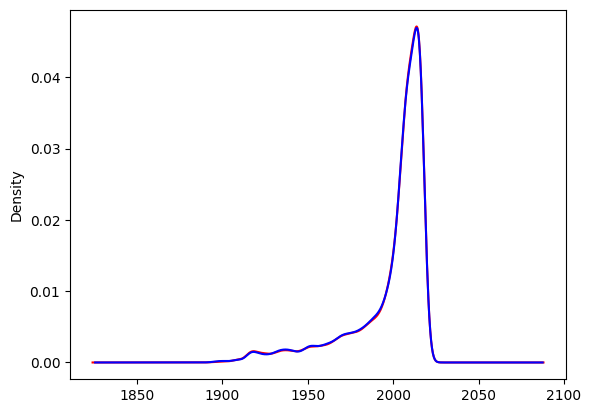

In [15]:
train['year'].plot(kind='kde',color='red')
test['year'].plot(kind='kde',color='blue')
plt.show()

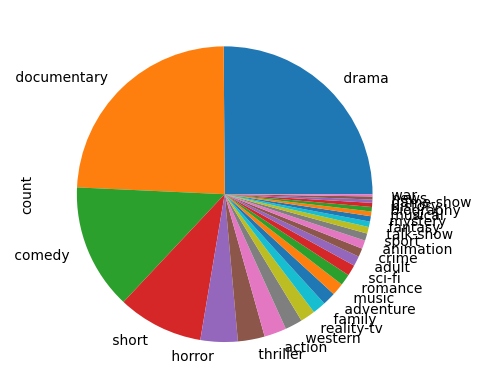

In [16]:
train['genre'].value_counts().plot(kind='pie')
plt.show()

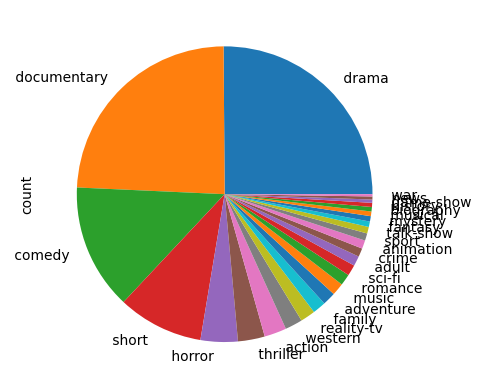

In [17]:
test['genre'].value_counts().plot(kind='pie')
plt.show()

In [18]:
# making x_train & y_train and x_test & y_test

x_train=train.drop('genre',axis=1)
y_train=train['genre']

x_test=test.drop('genre',axis=1)
y_test=test['genre']

In [19]:
# for imputing missing values
tran_imputing_na_101 = ColumnTransformer(
    [("fill_na", SimpleImputer(missing_values=np.nan, strategy='mean'), [-1])],remainder='passthrough')

# put bins on year column
tran_binning_102 = ColumnTransformer(
    [("binning_year", KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile'), [0])],remainder='passthrough')

pipeline_101 = Pipeline([('Imputing_values',tran_imputing_na_101),('Binning',tran_binning_102)])

In [20]:
x_train=pipeline_101.fit_transform(x_train)
x_test=pipeline_101.fit_transform(x_test)

In [21]:
class merge(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,data,y=None):
        return self
    def transform(self,data,y=None):
        #data=np.array(data)
        for i in range(data.shape[0]):
            one_cell=''
            for individual in data[i]:
                one_cell += str(individual)
            data[i]=one_cell
        return data[:,:1].flatten()


# merging all the individual columns and making them one
pipeline_201 = Pipeline([('merging_columns_into_single',merge())])

In [22]:
x_train=pipeline_201.fit_transform(x_train)
x_test=pipeline_201.fit_transform(x_test)

In [23]:
class text_processing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,data,y=None):
        return self
    def transform(self,data,y=None):
        for i in range(data.shape[0]):
            filter_token=''
            for token in nlp(data[i]):
                if not token.is_punct and not token.is_stop:
                    filter_token+=(token.lower_+' ')
            data[i]=filter_token
        return data


nlp=spacy.load('en_core_web_sm') # making a spacy object
# implementing text processing
pipeline_301 = Pipeline([('merging_columns_into_single',text_processing())])

In [24]:
x_train=pipeline_301.fit_transform(x_train)
x_test=pipeline_301.transform(x_test)

In [25]:
pipeline_401 = Pipeline([('tf_idf_vector',TfidfVectorizer())])

In [26]:
x_train=pipeline_401.fit_transform(x_train)
x_test=pipeline_401.transform(x_test)

In [27]:
# converting numpy sparase metrics to Scipy metrics

x_train=sparse.csr_matrix(x_train)
x_test=sparse.csr_matrix(x_test)

In [28]:
# Performing Label Encoding on Output Column

label_encoder=LabelEncoder()

y_train=label_encoder.fit_transform(y_train)
y_test=label_encoder.fit_transform(y_test)

## Implementing different Models

In [29]:
clf = BernoulliNB(alpha=2,fit_prior=False,binarize=0.019).fit(x_train,y_train)
y_pred=clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.4537822878228782

In [30]:
neigh = KNeighborsClassifier(n_neighbors=230,weights='distance').fit(x_train,y_train)
y_pred=neigh.predict(x_test)
accuracy_score(y_test, y_pred)

0.46870848708487084

In [31]:
rfc = RandomForestClassifier(n_estimators=195, random_state=42).fit(x_train,y_train)
y_pred=rfc.predict(x_test)
accuracy_score(y_test, y_pred)

0.49308118081180813

In [32]:
clf = LogisticRegression(multi_class='multinomial',solver='saga').fit(x_train,y_train)
y_pred=clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.5897416974169741